In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext zipline
import zipline

In [3]:
from zipline.api import order_target_percent, record, symbol, set_benchmark, get_open_orders
from datetime import datetime
import pytz

In [4]:
def initialize(context):
    context.i = 0
    context.asset = symbol('AAPL')
    set_benchmark(symbol('AAPL'))

In [5]:
def handle_data(context, data):
    # Skip first 200 days to get full windows
    context.i += 1
    if context.i < 200:
         return
    # Compute averages
    # data.history() has to be called with the same params
    # from above and returns a pandas dataframe.
    short_mavg = data.history(context.asset, 'price', bar_count=50, frequency="1d").mean()
    long_mavg = data.history(context.asset, 'price', bar_count=200, frequency="1d").mean()

    # Trading logic
    open_orders = get_open_orders()
    
    if context.asset not in open_orders:
        if short_mavg > long_mavg:
            # order_target orders as many shares as needed to
            # achieve the desired number of shares.
            order_target_percent(context.asset, 1.0)
        elif short_mavg < long_mavg:
            order_target_percent(context.asset, 0.0)

    # Save values for later inspection
    record(AAPL=data.current(context.asset, 'price'),
           short_mavg=short_mavg,
           long_mavg=long_mavg)

In [9]:
start = datetime(2012, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2017, 1, 1, 0, 0, 0, 0, pytz.utc)

perf = zipline.run_algorithm(start=start,
                      end=end,
                      initialize=initialize,
                      capital_base=10000,
                      handle_data=handle_data)

Start date,2012-01-03
End date,2016-12-30
Total months,59
,Backtest
Annual return,9.2%
Cumulative returns,55.1%
Annual volatility,16.9%
Sharpe ratio,0.61
Calmar ratio,0.41
Stability,0.70
Max drawdown,-22.4%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,22.45,2015-02-23,2015-08-24,NaT,NaN
1,18.83,2012-10-16,2013-09-16,2013-11-29,294
2,12.32,2013-12-23,2014-01-30,2014-04-25,90
3,10.92,2014-11-26,2015-01-16,2015-02-04,51
4,6.81,2014-09-02,2014-10-16,2014-10-23,38


Stress Events,mean,min,max
EZB IR Event,0.00%,0.00%,0.00%
Apr14,0.46%,-1.57%,8.19%
Oct14,0.31%,-1.56%,2.71%
Fall2015,-0.07%,-6.11%,5.73%
Recovery,-0.06%,-6.20%,6.93%
New Normal,0.07%,-7.98%,8.19%


Top 10 long positions of all time,max
sid,
AAPL,100.07%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
AAPL,100.07%


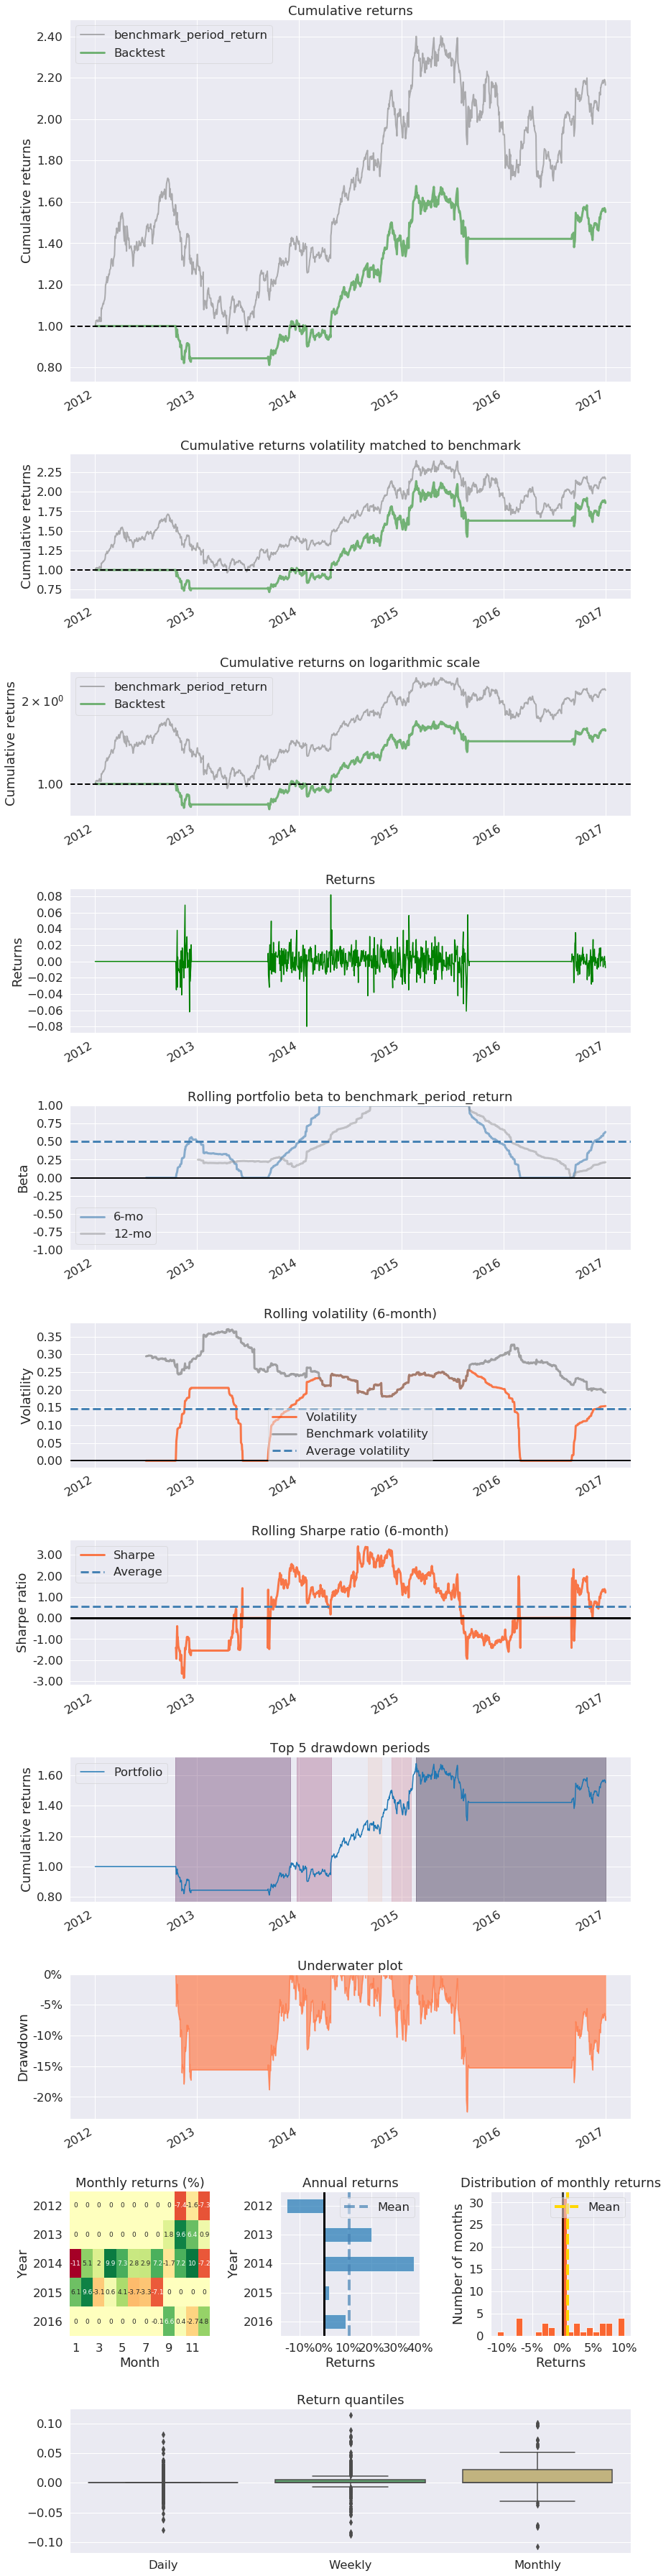

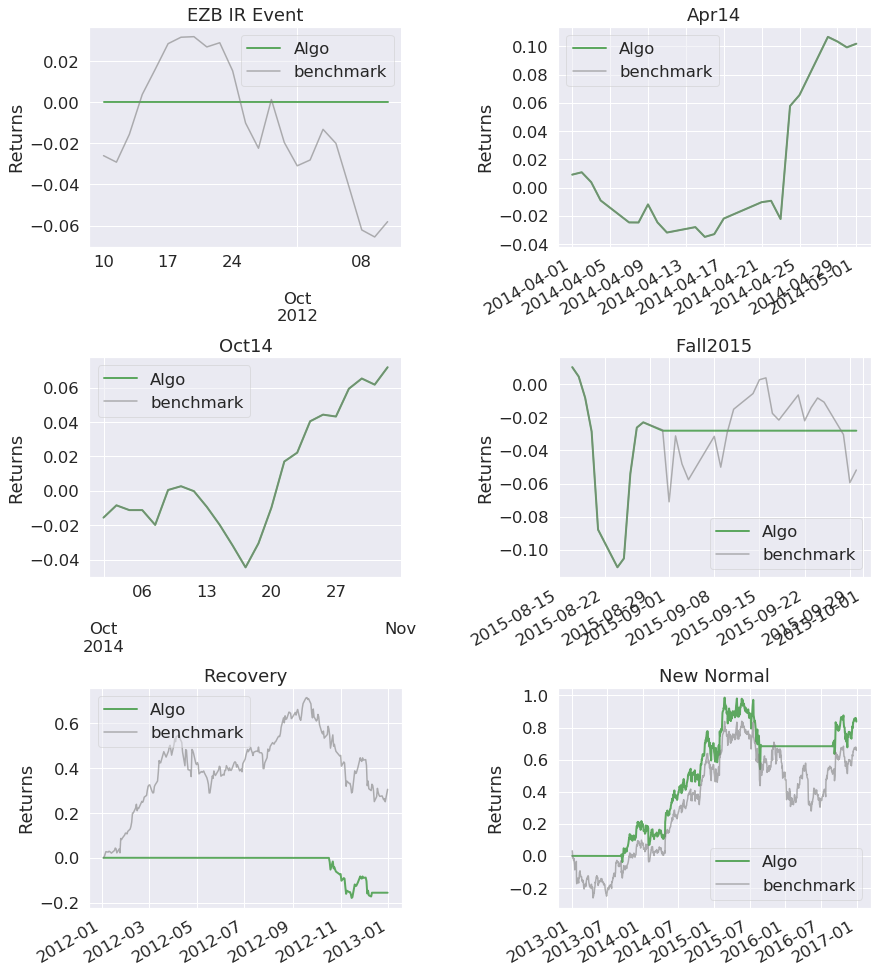

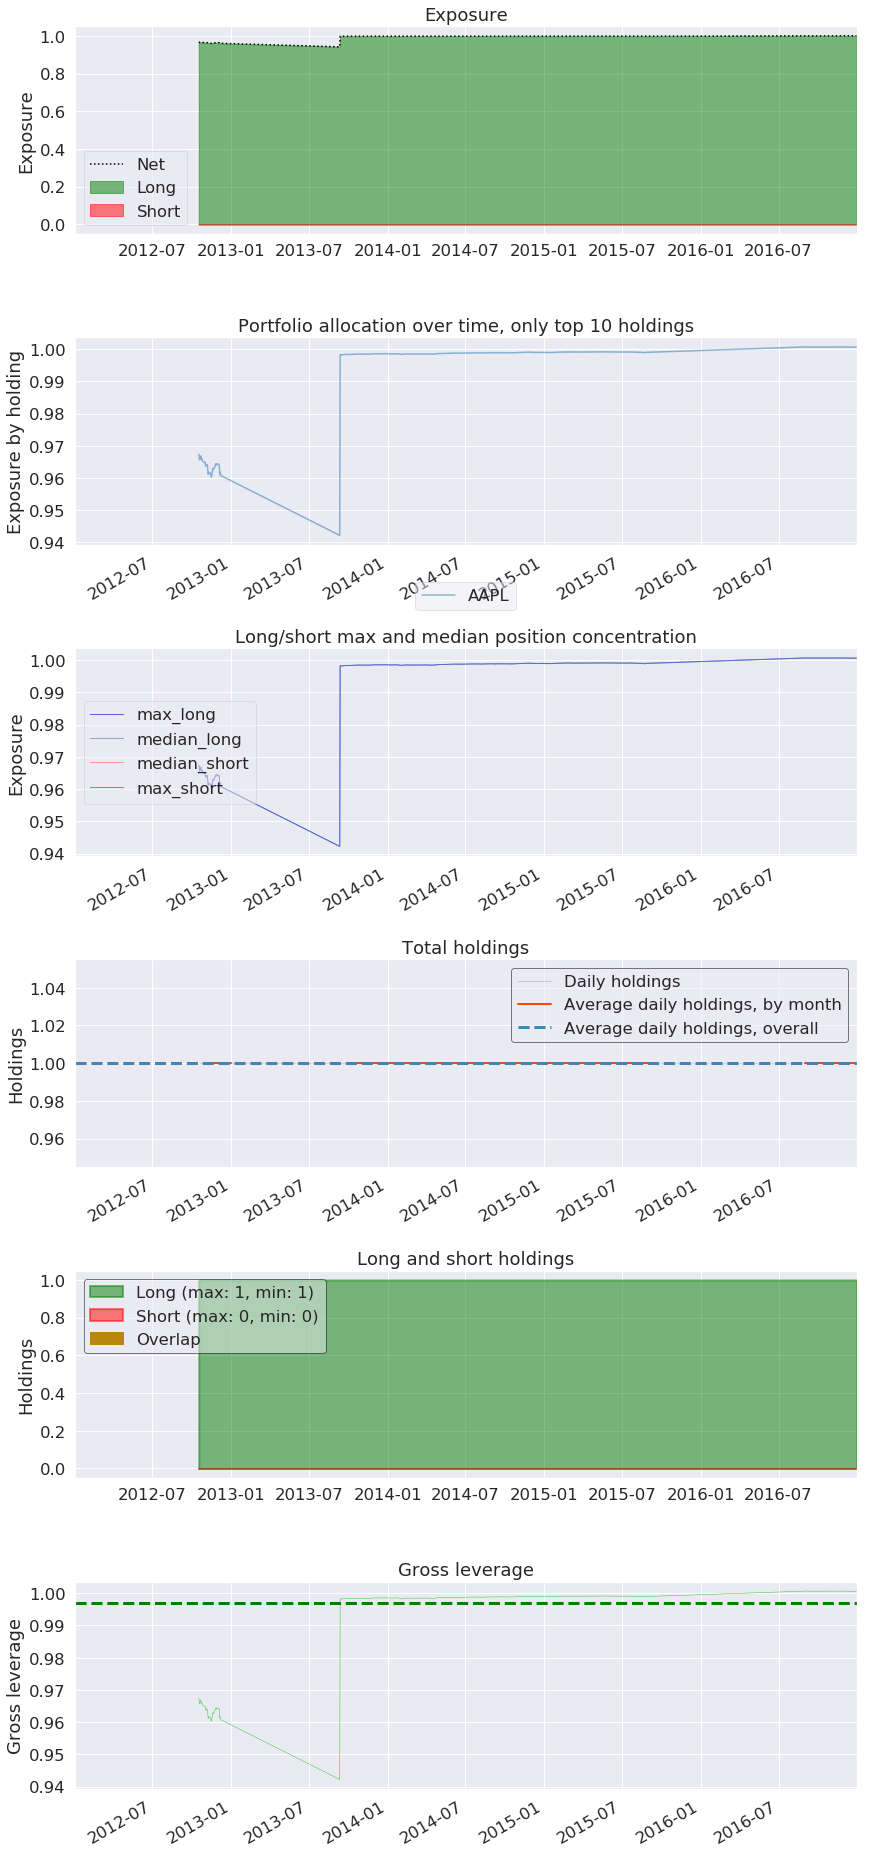

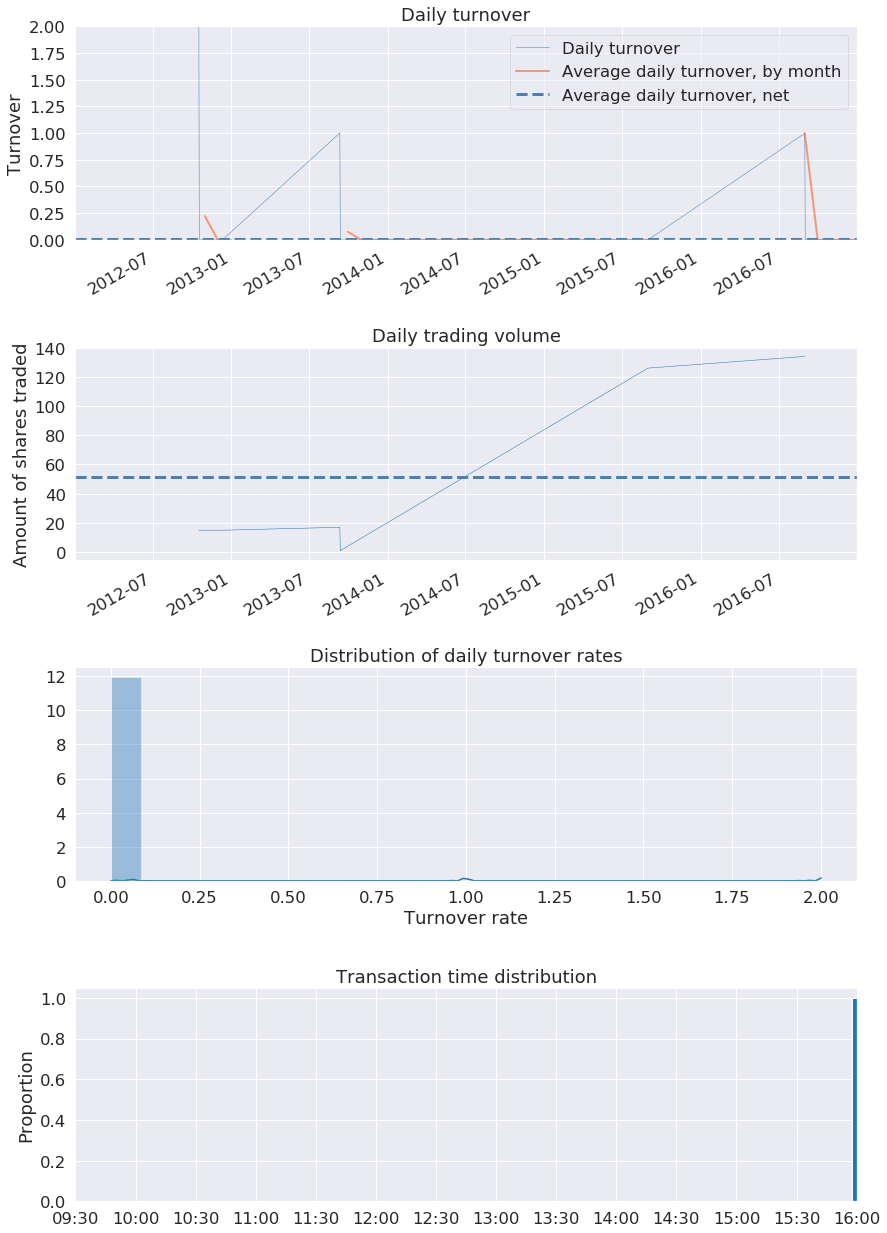

In [10]:
import pyfolio as pf
import numpy as np

# Extract algo returns and benchmark returns
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
benchmark_period_return = perf['benchmark_period_return']

# Convert benchmark returns to daily returns
#daily_returns = (1 + benchmark_period_return) / (1 + benchmark_period_return.shift()) - 1
daily_benchmark_returns = np.exp(np.log(benchmark_period_return + 1.0).diff()) - 1

# Create tear sheet
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, benchmark_rets=daily_benchmark_returns)


## Example to calculate daily returns from cumulative returns

In [11]:
import pandas as pd

# We need to be able to calulate the daily returns from the cumulative returns
daily_returns = pd.Series([0.5, -0.5, 0.5, -0.5])
cumulative_returns = pd.Series([0.5, -0.25, 0.125, 0.5625])

# Two different formulas to calculate daily returns
print((1 + cumulative_returns) / (1 + cumulative_returns.shift()) -1)
print((np.exp(np.log(cumulative_returns + 1).diff()) - 1))

# Recreate daily returns manually for example purposes
print(daily_returns.head(1))
print((1 - 0.25) / (1.5) - 1)
print((1 + 0.125) / (1 - 0.25) - 1)
print((1 + 0.5625) / (1 + 0.125 ) - 1)

0         NaN
1   -0.500000
2    0.500000
3    0.388889
dtype: float64
0         NaN
1   -0.500000
2    0.500000
3    0.388889
dtype: float64
0    0.5
dtype: float64
-0.5
0.5
0.38888888888888884
